# 1. Remake Triplet dataset
t-SNE로 잘 출력되는 것을 확인했지만, 데이터셋에 label 정보가 없어 클래스별 구분을 못했다. <br/>
triplet_list.txt의 line마다 label 정보를 추가할 것이다.

- 기존(size 3): anchor_idx, negative_idx, positive_idx
- 변경(size 4): anchor_idx, negative_idx, positive_idx, anchor_label

anchor_label은 같은 클래스끼리 **임의의 정수**를 부여할 것이다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/')

In [ ]:
import numpy as np
import os
import io
import csv
from common.dataset import PickledImageProvider
from common.dataset import KoreanFontDataset
from common.utils import pad_seq, bytes_to_file, \
    read_split_image, shift_and_resize_image, normalize_image, \
    tight_crop_image, add_padding

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dset = KoreanFontDataset(PickledImageProvider('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/dataset/kor/latent.obj'), vector_size=10)

In [6]:
dset[0]

({'font_doc2vec': [2.2403063999999997,
   -1.4756056999999998,
   -0.593018,
   -0.18605323,
   -1.2381212,
   -1.161201,
   2.8255024,
   0.10454782,
   -0.16260550000000001,
   1.2440913999999998],
  'font_index': 0,
  'word_index': 0},
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

In [ ]:
def make_triplet_list(ntriplets, font_indexes, file_name):
    print('Processing Triplet Generation ...')
    np_labels = font_indexes 
    filename = file_name
 
    triplets = []
    font_size = int(ntriplets / 2350)
    for class_idx in list(set(np_labels)): 
        try:
            a = np.random.choice(np.where(np_labels==class_idx)[0], int(ntriplets/font_size), replace=True) # 2350 anchor
            b = np.random.choice(np.where(np_labels==class_idx)[0], int(ntriplets/font_size), replace=True) # 2350 positive
            while np.any((a-b)==0):
                np.random.shuffle(b)
            c = np.random.choice(np.where(np_labels!=class_idx)[0], int(ntriplets/font_size), replace=True) # 2350 negative
            
            for i in range(a.shape[0]):
                triplets.append([int(a[i]), int(c[i]), int(b[i]), int(class_idx)]) # [anchor, negative, positive, anchor_label]           
        except Exception as e:
            print('exception font index:', class_idx)
            print(e)
    with open(os.path.join('./', filename), "w") as f:
        writer = csv.writer(f, delimiter=' ')
        writer.writerows(triplets)
    print('Done!')

In [ ]:
font_indexes = []
for i in range(len(dset)):
    font_indexes.append(dset[i][0]['font_index'])
font_indexes = np.array(font_indexes)

In [ ]:
make_triplet_list(251450, font_indexes, 'triplet_list_with_label.txt')

Processing Triplet Generation ...
Done!


---
# 2. Fix TripletImageLoader
- init 과정에서 anchor label을 저장하는 list를 추가할 것이다.
- 3개의 이미지를 반환하는 기존 return 값에서 anchor label과 anchor index까지 반환하도록 수정할 것이다.

In [ ]:
from PIL import Image
import os
import os.path

import torch.utils.data
import torchvision.transforms as transforms

def default_image_loader(path):
    return Image.open(path).convert('RGB')

class TripletImageLoader(torch.utils.data.Dataset): 
    def __init__(self, pickled, triplets_file_name, base_path=None, filenames_filename=None, transform=None,
                 loader=default_image_loader):
        """ 
        filenames_filename: 
            A text file with each line containing the path to an image e.g.,
            images/class1/sample.jpg
                
        triplets_file_name: 
            A text file with each line containing three integers, 
            where integer i refers to the i-th image in the filenames file. 
            For a line of intergers 'a b c', a triplet is defined such that image a is more 
            similar to image c than it is to image b, 
            e.g., 0 2017 42 
        """
        self.dset = pickled.examples
#         self.base_path = base_path  
#         self.filenamelist = []
#         for line in open(filenames_filename):
#             self.filenamelist.append(line.rstrip('\n'))
        triplets = []
        anchor_labels = [] #
        for line in open(triplets_file_name):
            triplets.append((line.split()[0], line.split()[1], line.split()[2])) # anchor, far, close
            anchor_labels.append(int(line.split()[3])) #
        self.triplets = triplets
        self.labels = anchor_labels #
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path1, path2, path3 = self.triplets[index]
        anchor_label = self.labels[index]
        img1_tuple = self.dset[int(path1)]
        img2_tuple = self.dset[int(path2)]
        img3_tuple = self.dset[int(path3)]
        
        info = {
            'anchor_index': int(path1),
            'anchor_label': anchor_label
        }
        
        # byte만 사용할 예정
        img1, byte_1 = img1_tuple[0], img1_tuple[1]
        img2, byte_2 = img2_tuple[0], img2_tuple[1]
        img3, byte_3 = img3_tuple[0], img3_tuple[1]
        
        # bytes 타입을 numpy array로 변경 후 normalize
        img_arr_1 = np.array(Image.open(io.BytesIO(byte_1)))
        img_arr_1 = normalize_image(img_arr_1)
        
        img_arr_2 = np.array(Image.open(io.BytesIO(byte_2)))
        img_arr_2 = normalize_image(img_arr_2)
        
        img_arr_3 = np.array(Image.open(io.BytesIO(byte_3)))
        img_arr_3 = normalize_image(img_arr_3)

        cropped_image_1, cropped_image_size_1 = tight_crop_image(img_arr_1, verbose=False)
        centered_image_1 = add_padding(cropped_image_1, verbose=False)
        
        cropped_image_2, cropped_image_size_2 = tight_crop_image(img_arr_2, verbose=False)
        centered_image_2 = add_padding(cropped_image_2, verbose=False)
        
        cropped_image_3, cropped_image_size_3 = tight_crop_image(img_arr_3, verbose=False)
        centered_image_3 = add_padding(cropped_image_3, verbose=False)
            
        return (centered_image_1, centered_image_2, centered_image_3), info #

    def __len__(self):
        return len(self.triplets)

In [ ]:
pickled = PickledImageProvider('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/dataset/kor/latent.obj')
triplet_loader = TripletImageLoader(pickled, '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/triplet_list_with_label.txt')

In [9]:
len(triplet_loader[1][0]) # anchor, negative, positive images

3

In [10]:
triplet_loader[1][1] # anchor label == 0 ( ~ triplet_loader[2349][1])

0

---
# 3. Load Trained Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import shutil
import os
import io

class Tripletnet(nn.Module):
    def __init__(self, embeddingnet):
        super(Tripletnet, self).__init__()
        self.embeddingnet = embeddingnet

    def forward(self, x, y, z):
        embedded_x = self.embeddingnet(x)
        embedded_y = self.embeddingnet(y)
        embedded_z = self.embeddingnet(z)
        dist_a = F.pairwise_distance(embedded_x, embedded_y, 2)
        dist_b = F.pairwise_distance(embedded_x, embedded_z, 2)
        return dist_a, dist_b, embedded_x, embedded_y, embedded_z

In [ ]:
# FontStyler의 convAE 코드 (layers.py)
class Encoder_conv(nn.Module):
    
    def __init__(self, img_dim=1, conv_dim=16): # output dim은 128이 될 것
        super(Encoder_conv, self).__init__()
        self.conv1 = conv2d(img_dim, conv_dim, k_size=5, stride=2, pad=2, dilation=2, lrelu=False, bn=False)
        self.conv2 = conv2d(conv_dim, conv_dim*2, k_size=5, stride=4, pad=2, dilation=2)
        self.conv3 = conv2d(conv_dim*2, conv_dim*4, k_size=4, stride=4, pad=1, dilation=1)
        self.conv4 = conv2d(conv_dim*4, conv_dim*8)
        self.conv5 = conv2d(conv_dim*8, conv_dim*8)
    
    def forward(self, images):
        # |images| = (batch, img, img)
        # print(images.shape)
        images = images.unsqueeze(dim=1)
        # |images| = (batch, 1, 128, 128)
        # print(images.shape)
        e1 = self.conv1(images)
        # |e1| = (batch, conv_dim, 64, 64)
        # print(e1.shape)
        e2 = self.conv2(e1)
        # |e2| = (batch, conv_dim*2, 16, 16)
        # print(e2.shape)
        e3 = self.conv3(e2)
        # |e3| = (batch, conv_dim*4, 4, 4)
        # print(e3.shape)
        e4 = self.conv4(e3)
        # |e4| = (batch, conv_dim*8, 2, 2)
        # print(e4.shape)
        encoded_source = self.conv5(e4)
        # |encoded_source| = (batch, conv_dim*8, 1, 1)
        # print(encoded_source.shape)
        
        return encoded_source

In [ ]:
# function.py
import torch.nn as nn

def batch_norm(c_out, momentum=0.1):
    return nn.BatchNorm2d(c_out, momentum=momentum)

def conv2d(c_in, c_out, k_size=3, stride=2, pad=1, dilation=1, bn=True, lrelu=True, leak=0.2):
    layers = []
    if lrelu:
        layers.append(nn.LeakyReLU(leak))
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def deconv2d(c_in, c_out, k_size=3, stride=1, pad=1, dilation=1, bn=True, dropout=False, p=0.5):
    layers = []
    layers.append(nn.LeakyReLU(0.2))
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    if dropout:
        layers.append(nn.Dropout(p))
    return nn.Sequential(*layers)

def lrelu(leak=0.2):
    return nn.LeakyReLU(leak)

def dropout(p=0.2):
    return nn.Dropout(p)

In [ ]:
checkpoint_pth = '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/runs/TripleNet/model_best.pth.tar'

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best = torch.load(checkpoint_pth)

# 학습된 TripletNet 로드
model = Encoder_conv()
tnet  = Tripletnet(model)
tnet.load_state_dict(best['state_dict'])

<All keys matched successfully>

In [27]:
tnet.cuda()

Tripletnet(
  (embeddingnet): Encoder_conv(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    )
    (conv2): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv4): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv5): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2)

In [ ]:
pickled = PickledImageProvider('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/dataset/kor/latent.obj')
triplet_loader = TripletImageLoader(pickled, '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/triplet_list_with_label.txt')

In [16]:
len(triplet_loader)

251450

In [21]:
triplet_loader[2350][1] # label이 출력되는지 확인

1

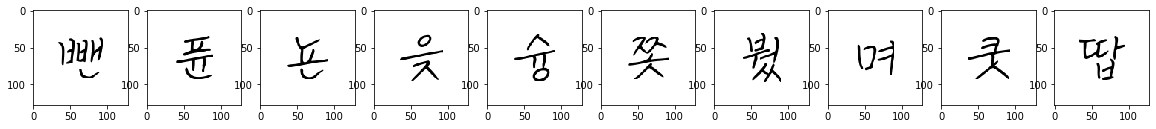

In [18]:
# anchor (이 이미지들을 Triplet network에 통과시켜 plotting할 것이다.)
plt.figure(figsize=(20, 10))
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.imshow(triplet_loader[idx+5000][0][0], cmap='gray', label=idx)
plt.show()

---
# 4. Make Latent Vectors

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
idxs = list(range(len(triplet_loader)))
np.random.shuffle(idxs)
batch_size = 32

sampler = SubsetRandomSampler(idxs) # 전체 샘플링
loader = torch.utils.data.DataLoader(
        triplet_loader,
        batch_size = batch_size,
        sampler = sampler
    )

In [ ]:
tnet.eval()
with torch.no_grad():
    anchors = []
    labels  = []
    for idx, ((img1, img2, img3), label) in enumerate(loader): 
        if device == 'cuda':
            img1, img2, img3 = img1.cuda(), img2.cuda(), img3.cuda()
        img1, img2, img3 = img1.float(), img2.float(), img3.float()

        _, _, anchor, _, _ = tnet(img1, img2, img3)
        anchors.append(anchor) 
        labels.append(label)
        if idx == 1000:
            break

In [30]:
len(anchors), len(labels) # 각 index마다 32개의 정보 포함(batch_size == 32)

(1001, 1001)

In [33]:
anchors[0].shape # 32 * (128*1*1)

torch.Size([32, 128, 1, 1])

In [34]:
labels[0].shape

torch.Size([32])

In [41]:
latent = np.zeros((1, 128, 1, 1))
for i in range(len(anchors)):
    latent = np.concatenate([latent, anchors[i].cpu()])
print('latent shape: {}'.format(latent.shape))

tmp_label = np.zeros((1))
for i in range(len(labels)):
    tmp_label = np.concatenate([tmp_label, labels[i].cpu()])
print('label shape: {}'.format(tmp_label.shape))

latent shape: (32033, 128, 1, 1)
label shape: (32033,)


In [42]:
tmp_label[1]

84.0

---
# 5. Plotting using t-SNE

In [ ]:
import random

def get_random_color():
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

In [46]:
print(get_random_color())
print(get_random_color())
print(get_random_color())

#3295F6
#B79FC9
#50BE1F


In [ ]:
# 107개 클래스별로 색상 할당
color_dict = dict()
for font_idx in range(107):
    color_dict[font_idx] = get_random_color()

In [54]:
color_dict[0], color_dict[1]

('#617AA4', '#AEE82E')

Text(0, 0.5, 't-SNE feature 1')

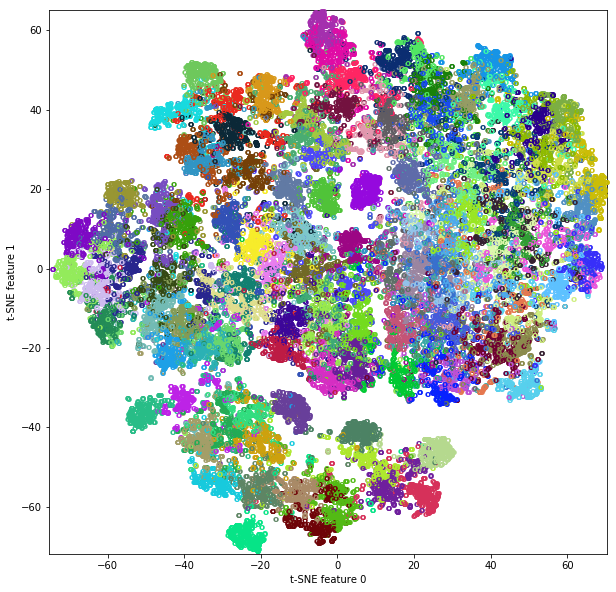

In [59]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)

temporal = tsne.fit_transform(latent.reshape(32033,128))

plt.figure(figsize=(10,10))
plt.xlim(temporal[:, 0].min(), temporal[:, 0].max() + 1)
plt.ylim(temporal[:, 1].min(), temporal[:, 1].max() + 1)
for i in range(len(temporal)): # 32033
    plt.text(temporal[i, 0], temporal[i, 1], str('o'), # todo: 클래스 별로 색 다르게 
            color = color_dict[int(tmp_label[i])],
            fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

와우.. 뭉친다.